In [106]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [107]:
import numpy
import torch
import typing

from holo.prettyFormats import prettyPrint
from holo.__typing import assertIsinstance

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [109]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper1

def cell():
    global handleDatas, train, MoE_models, basicModels
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    MoE_models.paper1 = importlib.reload(MoE_models.paper1)

cell();

In [110]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256)

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10](total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]


In [163]:
def cell():
    gatingModel, experts, loss = basicModels.BasicImageClassifModel.get_Cifar_like_32x32x3_moe(
        device=device, nbClasses=datasHandler.nbClasses, 
        gatingModelConfig='small', nbExperts=4, expertsModelConfig="medium")
    moeModel = MoE_models.paper1.MOE_Model(
        experts=experts, gatingModel=gatingModel, isClassif=True)
    return moeModel, loss
model, baseLoss = cell(); del cell
hist = train.HistoryClassification()
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
print(f"nbParams gating: {basicModels.countTotalParameters(model.gatingModel.parameters()):_d}")
print(f"""nbParams experts: [{', '.join([f"{basicModels.countTotalParameters(expert.parameters()):_d}" for expert in model.experts])}]""")

trainer = train.TrainerClassif_MoE1(model=model, optimizer=optim, criterion=baseLoss, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
assert _[1].shape == (1, datasHandler.nbClasses, model.nbExperts), f"{_[1].shape = }"
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

nbParams total: 1_799_244
nbParams gating: 27_748
nbParams experts: [442_874, 442_874, 442_874, 442_874]


In [164]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=10);

Epoch 1, train: (loss: 0.7759, accuracy: 48.50%), test: (loss: 0.6415, accuracy: 58.40%), lr: 1.0000e-03
Epoch 2, train: (loss: 0.5279, accuracy: 66.70%), test: (loss: 0.5851, accuracy: 63.53%), lr: 1.0000e-03
Epoch 3, train: (loss: 0.4311, accuracy: 73.57%), test: (loss: 0.5122, accuracy: 68.75%), lr: 1.0000e-03
Epoch 4, train: (loss: 0.3745, accuracy: 77.09%), test: (loss: 0.4151, accuracy: 76.28%), lr: 1.0000e-03
Epoch 5, train: (loss: 0.3255, accuracy: 80.23%), test: (loss: 0.483, accuracy: 71.57%), lr: 1.0000e-03
Epoch 6, train: (loss: 0.2899, accuracy: 82.73%), test: (loss: 0.4529, accuracy: 73.38%), lr: 1.0000e-03
Epoch 7, train: (loss: 0.2553, accuracy: 84.65%), test: (loss: 0.4024, accuracy: 75.99%), lr: 1.0000e-03
Epoch 8, train: (loss: 0.2204, accuracy: 86.74%), test: (loss: 0.4017, accuracy: 76.06%), lr: 1.0000e-03
Epoch 9, train: (loss: 0.1899, accuracy: 88.33%), test: (loss: 0.3841, accuracy: 77.60%), lr: 1.0000e-03
Epoch 10, train: (loss: 0.1622, accuracy: 90.21%), test:

In [ ]:
for h in trainer.history:
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(" ->", h.epochID)
        rnd = 2
        #print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).nbPred.round(rnd))
        #print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).nbTruth.round(rnd))
        print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).nbPred - assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).nbTruth)
        print(assertIsinstance(train.Moe1ExpertsInsigths, h.train.moeExpertsInsigths).meanExpertsGate().round(rnd))
        print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).meanExpertsGate().round(rnd))
        print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).meanPredClassesExpertsGate().round(rnd).T)
        print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).meanPredClassesExpertsGate().std(axis=1).round(rnd))
        #print(assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).meanTruthClassesExpertsGate().round(rnd).T)
        #print((assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).meanPredClassesExpertsGate() - assertIsinstance(train.Moe1ExpertsInsigths, h.test.moeExpertsInsigths).meanTruthClassesExpertsGate()).round(rnd).T)
        print()

 -> 1
[ -43 1141 -179  488 -293 -261 -188  -30 -381 -254]
[0.25 0.24 0.29 0.23]
[0.34 0.17 0.27 0.23]
[[0.79 0.4  0.31 0.17 0.16 0.25 0.09 0.17 0.76 0.32]
 [0.03 0.13 0.18 0.23 0.24 0.21 0.25 0.21 0.04 0.14]
 [0.11 0.26 0.26 0.31 0.3  0.28 0.33 0.33 0.14 0.32]
 [0.06 0.2  0.24 0.29 0.29 0.26 0.33 0.29 0.07 0.23]]
[0.31 0.1  0.05 0.05 0.06 0.02 0.1  0.06 0.3  0.08]

[0.16 0.19 0.13 0.15 0.15 0.14 0.2  0.13 0.13 0.16]
 -> 2
[-244 -470 -473 -988 1648 -315  103  213   98  428]
[0.15 0.23 0.33 0.29]
[0.04 0.26 0.37 0.33]
[[0.2  0.01 0.08 0.01 0.01 0.   0.   0.   0.15 0.02]
 [0.17 0.28 0.26 0.31 0.29 0.3  0.29 0.28 0.19 0.26]
 [0.32 0.37 0.34 0.37 0.37 0.38 0.38 0.38 0.34 0.38]
 [0.31 0.34 0.32 0.31 0.33 0.32 0.32 0.33 0.32 0.34]]
[0.06 0.14 0.1  0.14 0.14 0.14 0.15 0.15 0.08 0.14]

[0.16 0.19 0.13 0.15 0.15 0.14 0.2  0.13 0.13 0.16]
 -> 3
[-319 -193 -142 -496  158 -359 1085 -413  238  441]
[0.13 0.24 0.34 0.29]
[0.1  0.27 0.39 0.24]
[[0.32 0.03 0.13 0.03 0.04 0.02 0.   0.01 0.39 0.03]
 [0.1

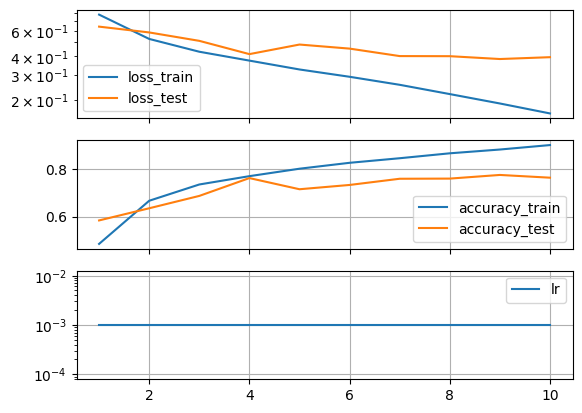

In [166]:
trainer.history.plot();

In [167]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
cell(); del cell

Epoch 1, train: (loss: 0.7759, accuracy: 48.50%), test: (loss: 0.6415, accuracy: 58.40%), lr: 1.0000e-03
        Epoch 2, train: (loss: 0.5279, accuracy: 66.70%), test: (loss: 0.5851, accuracy: 63.53%), lr: 1.0000e-03
        Epoch 3, train: (loss: 0.4311, accuracy: 73.57%), test: (loss: 0.5122, accuracy: 68.75%), lr: 1.0000e-03
        Epoch 4, train: (loss: 0.3745, accuracy: 77.09%), test: (loss: 0.4151, accuracy: 76.28%), lr: 1.0000e-03
        Epoch 5, train: (loss: 0.3255, accuracy: 80.23%), test: (loss: 0.483, accuracy: 71.57%), lr: 1.0000e-03
        Epoch 6, train: (loss: 0.2899, accuracy: 82.73%), test: (loss: 0.4529, accuracy: 73.38%), lr: 1.0000e-03
        Epoch 7, train: (loss: 0.2553, accuracy: 84.65%), test: (loss: 0.4024, accuracy: 75.99%), lr: 1.0000e-03
        Epoch 8, train: (loss: 0.2204, accuracy: 86.74%), test: (loss: 0.4017, accuracy: 76.06%), lr: 1.0000e-03
        Epoch 9, train: (loss: 0.1899, accuracy: 88.33%), test: (loss: 0.3841, accuracy: 77.60%), lr: 1.0

In [168]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[ 981   18   60   20   19    6    5   13   58   54]
 [  17 1055    3    3    6    5    6    3   22  160]
 [  46   11  873   74   72   39   50   28   14    6]
 [  10    5   39  607   29  113   41   23   14   15]
 [  15    2   79   55  878   52   33   60    8   10]
 [  12    8   82  280   53  935   42   71    5   17]
 [   4    9   65   63   38   26 1001    6    9    3]
 [  10    5   24   37   44   39    2  925    7   12]
 [  81   37   29   28   24   16   15   14 1092   35]
 [  21   59    7   19    2   14    3   16   13  826]]

class: 0, precision:79.50%, hitRate: 81.95%
class: 1, precision:82.42%, hitRate: 87.26%
class: 2, precision:71.97%, hitRate: 69.23%
class: 3, precision:67.75%, hitRate: 51.18%
class: 4, precision:73.66%, hitRate: 75.36%
class: 5, precision:62.13%, hitRate: 75.10%
class: 6, precision:81.78%, hitRate: 83.56%
class: 7, precision:83.71%, hitRate: 79.81%
class: 8, precision:79.65%, hitRate: 87.92%
class: 9, precision:84.29%, hitRate: 72.58%

[
    (0.09904492394764769,